<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_4_empirical_risk.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Empirical Risk Minimization and Model Evaluation

In this assignment, you will learn how empirical risk minimization relates to model performance, and how concepts like approximation error, estimation error, regularization, structural risk minimization, and cross-validation help build better models.

---

## Learning Goals
- Understand **approximation error** vs **estimation error**
- Understand **regularized risk minimization**
- Understand **structural risk minimization**
- Apply **cross-validation** to evaluate models


## 1. Empirical Risk & Error Decomposition

- **Empirical Risk Minimization (ERM):** we choose a hypothesis that minimizes the average loss on training data.  
- **Approximation Error:** error due to limited model class (e.g., linear models can’t fit curved patterns).  
- **Estimation Error:** error due to limited data or overfitting.

$\text{Total Error} = \text{Approximation Error} + \text{Estimation Error}$


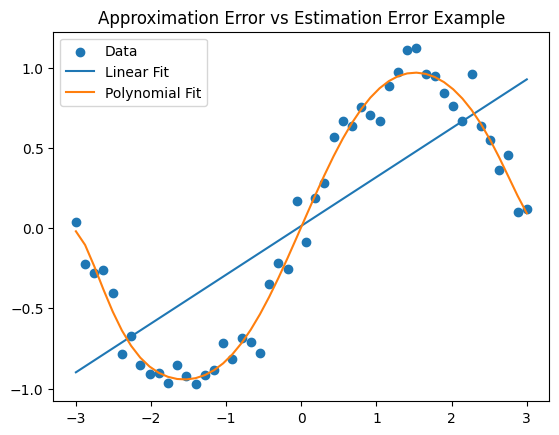

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate nonlinear data
np.random.seed(0)
X = np.linspace(-3, 3, 50).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.1, X.shape)

# Linear fit (high approx. error, low est. error)
lin = LinearRegression().fit(X, y)
y_lin = lin.predict(X)

# Polynomial fit (low approx. error, higher est. error risk)
poly = PolynomialFeatures(degree=10)
X_poly = poly.fit_transform(X)
lin_poly = LinearRegression().fit(X_poly, y)
y_poly = lin_poly.predict(X_poly)

plt.scatter(X, y, label="Data")
plt.plot(X, y_lin, label="Linear Fit")
plt.plot(X, y_poly, label="Polynomial Fit")
plt.legend()
plt.title("Approximation Error vs Estimation Error Example")
plt.show()


### Exercise 1
- Fit polynomial models of degree 2, 5, and 15 to the same data.  
- Compare their training error and test error (use a held-out test set).  
- Which models show more approximation error? Which show more estimation error?


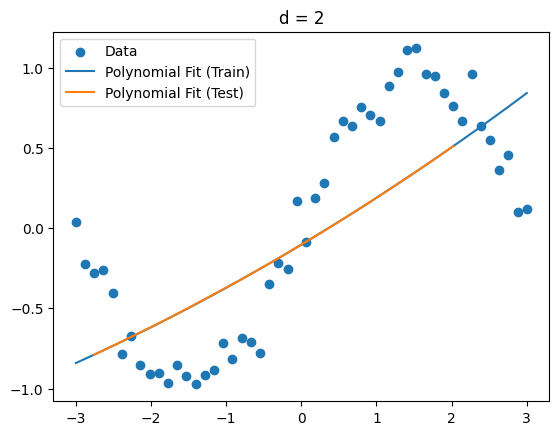

Degree 2: Train MSE = 0.210, Test MSE = 0.207



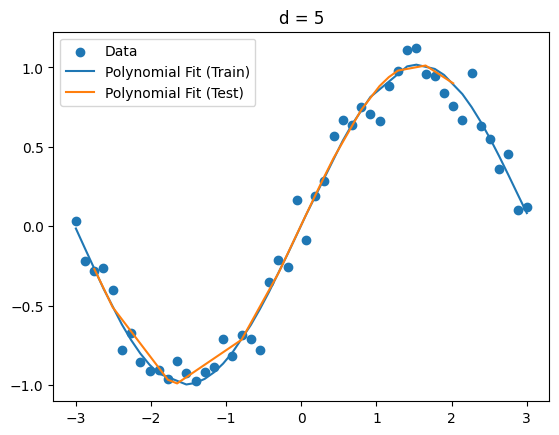

Degree 5: Train MSE = 0.012, Test MSE = 0.009



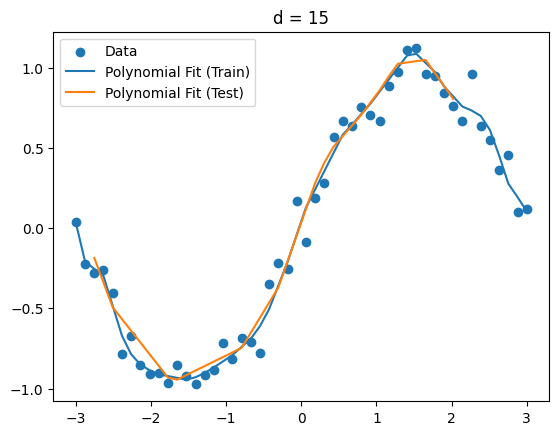

Degree 15: Train MSE = 0.009, Test MSE = 0.009



In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

degrees = [2, 5, 15]

for d in degrees:
    poly_d = PolynomialFeatures(degree=d)

    # Fit/transform training data
    X_poly_d_train = poly_d.fit_transform(X_train)
    lin_poly_d = LinearRegression().fit(X_poly_d_train, y_train)

    # Predictions on training data
    y_poly_d_train = lin_poly_d.predict(X_poly_d_train)

    # Transform test data
    X_poly_d_test = poly_d.transform(X_test)
    y_poly_d_test = lin_poly_d.predict(X_poly_d_test)

    train_sort_idx = np.argsort(X_train[:, 0])
    X_train_sorted = X_train[train_sort_idx]
    y_poly_d_train_sorted = y_poly_d_train[train_sort_idx]

    test_sort_idx = np.argsort(X_test[:, 0])
    X_test_sorted = X_test[test_sort_idx]
    y_poly_d_test_sorted = y_poly_d_test[test_sort_idx]

    plt.scatter(X, y, label="Data")
    plt.plot(X_train_sorted, y_poly_d_train_sorted, label="Polynomial Fit (Train)")
    plt.plot(X_test_sorted, y_poly_d_test_sorted, label="Polynomial Fit (Test)")
    plt.legend()
    plt.title("d = " + str(d))
    plt.show()

    train_error = mean_squared_error(y_train, y_poly_d_train)
    test_error = mean_squared_error(y_test, y_poly_d_test)
    print(f"Degree {d}: Train MSE = {train_error:.3f}, Test MSE = {test_error:.3f}\n")

Which models show more approximation error? Which show more estimation error?

d = 2 DEFINITELY has the most approximation error; not even a question. d = 5 & 15 both have about the same amount of error, but d = 15 is more "bumpy," which has me concerned that it could be starting to overfit.

## 2. Regularized Risk

To reduce overfitting, we add a penalty term to the empirical risk:

$R_{\text{reg}}(h) = R_{\text{emp}}(h) + \lambda \cdot \Omega(h)$

- $R_{\text{emp}}$: training error  
- $\Omega(h)$: complexity of hypothesis (e.g., large weights)  
- $\lambda$: regularization strength  

Examples: **Ridge (L2)**, **Lasso (L1)**.


In [3]:
from sklearn.linear_model import Ridge, Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

ridge = Ridge(alpha=1.0).fit(X_train, y_train)
lasso = Lasso(alpha=0.1, max_iter=10000).fit(X_train, y_train)

print("Ridge test error:", mean_squared_error(y_test, ridge.predict(X_test)))
print("Lasso test error:", mean_squared_error(y_test, lasso.predict(X_test)))


Ridge test error: 0.19979823539881267
Lasso test error: 0.21281469910574363


### Exercise 2
Experiment with different values of λ for Ridge regression.  
- How does increasing λ affect training error?  
- How does it affect test error?  
- Why?


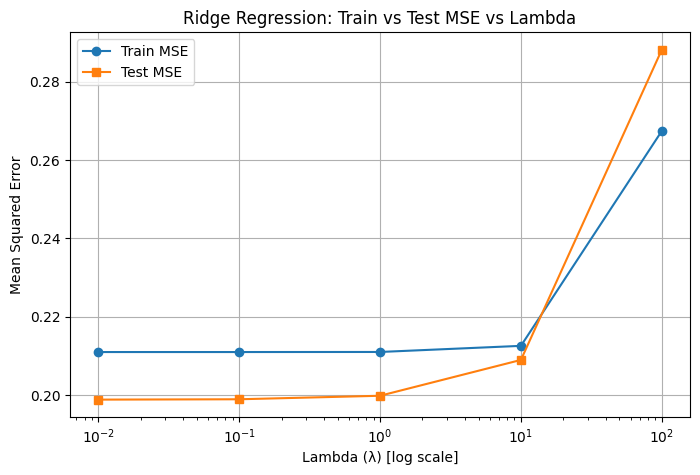

λ = 0.01: Train MSE = 0.211, Test MSE = 0.199
λ = 0.1: Train MSE = 0.211, Test MSE = 0.199
λ = 1.0: Train MSE = 0.211, Test MSE = 0.200
λ = 10.0: Train MSE = 0.213, Test MSE = 0.209
λ = 100.0: Train MSE = 0.267, Test MSE = 0.288


In [4]:
lambdas = [0.01, 0.1, 1.0, 10.0, 100.0]

train_errors = []
test_errors = []

for l in lambdas:
    ridge = Ridge(alpha=l).fit(X_train, y_train)
    train_errors.append(mean_squared_error(y_train, ridge.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, ridge.predict(X_test)))

# Plot
plt.figure(figsize=(8,5))
plt.plot(lambdas, train_errors, marker='o', label='Train MSE')
plt.plot(lambdas, test_errors, marker='s', label='Test MSE')
plt.xscale('log')  # logarithmic scale for lambda
plt.xlabel('Lambda (λ) [log scale]')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression: Train vs Test MSE vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

for l, train_err, test_err in zip(lambdas, train_errors, test_errors):
    print(f"λ = {l}: Train MSE = {train_err:.3f}, Test MSE = {test_err:.3f}")

Neither error changes from λ = .01 to λ = 1, but then both start increasing as λ increases. The test error increases more rapidly as the model is forced to keep coefficients smaller, reducing its ability to fit the training data closely, introducing greater bias and reducing accuracy.

## 3. Structural Risk Minimization

ERM chooses the best hypothesis within a model class.  
**Structural Risk Minimization (SRM)** considers a sequence of model classes of increasing complexity, balancing fit and capacity.

- Small models → high approximation error, low estimation error.  
- Large models → low approximation error, high estimation error risk.  

SRM chooses the model class with best **generalization**.


### Exercise 3
Train polynomial regressors with degrees from 1 to 15.  
- Plot training and test error against model degree.  
- Which degree minimizes test error?  
- How does this illustrate SRM?


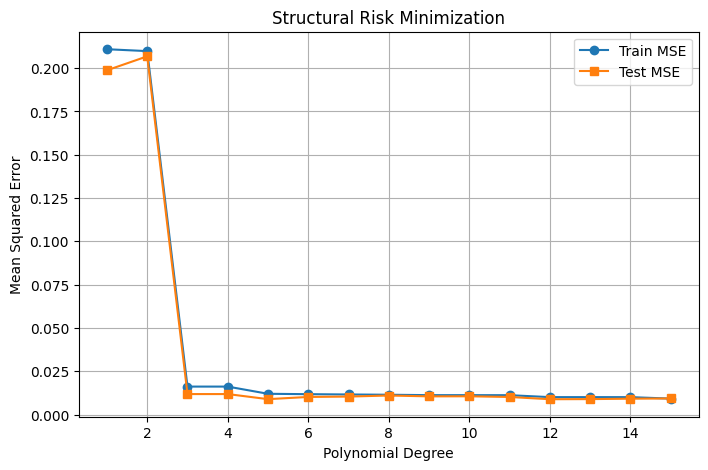

Degree that minimizes test error: 12


In [5]:
degrees = range(1, 16)
train_errors = []
test_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    model = LinearRegression().fit(X_poly_train, y_train)

    train_errors.append(mean_squared_error(y_train, model.predict(X_poly_train)))
    test_errors.append(mean_squared_error(y_test, model.predict(X_poly_test)))

plt.figure(figsize=(8,5))
plt.plot(degrees, train_errors, marker='o', label='Train MSE')
plt.plot(degrees, test_errors, marker='s', label='Test MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Structural Risk Minimization')
plt.legend()
plt.grid(True)
plt.show()

best_degree = degrees[np.argmin(test_errors)]
print(f"Degree that minimizes test error: {best_degree}")

d = 12 minimizes test error, illustrating SRM by being the model with the best ability to generalize when compared to the other degrees.

## 4. Cross-Validation

Cross-validation estimates model performance by splitting data into multiple training/test folds.

- **k-fold cross-validation:** split data into k folds, train on k-1, test on 1, rotate.  
- Provides a more stable estimate of generalization error.  


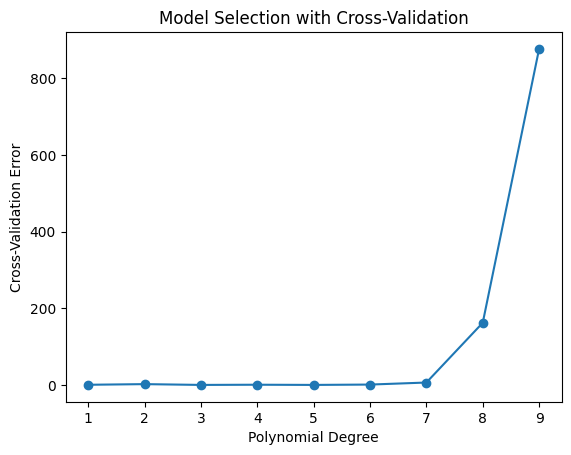

Degree that minimizes cross-validation error: 3


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

degrees = range(1, 10)
cv_scores = []

for d in degrees:
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
    cv_scores.append(-scores.mean())

plt.plot(degrees, cv_scores, marker="o")
plt.xlabel("Polynomial Degree")
plt.ylabel("Cross-Validation Error")
plt.title("Model Selection with Cross-Validation")
plt.show()

best_degree = degrees[np.argmin(cv_scores)]
print(f"Degree that minimizes cross-validation error: {best_degree}")


### Exercise 4
- Which polynomial degree minimizes cross-validation error?  
- How does this compare to training/test error without cross-validation?  
- Why is cross-validation more reliable?

Degree that minimizes cross-validation error: 3.
Before, the best degree was 12.

Cross-validation is more reliable because it uses multiple tests to determine the best option, as opposed to taking one random split that may be (un)lucky.

## 5. Reflection

### Exercise 5
Answer in 2–3 sentences each:

1. What is the difference between approximation error and estimation error?  
2. How does regularization reduce overfitting?  
3. Why is cross-validation preferred over a single train/test split?


1. Approximation Error comes from a model not being flexible enough to fit the data. The Estimation Error comes from being too flexible and losing the ability to generalize.

2. Regularization reduces overfitting by adding a penalty for large coefficients. This penalty discourages the model from fitting to outliers.

3. Cross-validation is preferred over a single train/test splits because it uses multiple tests to determine the best option, as opposed to taking one random split that may be (un)lucky. This provides a more reliable generalization ability.